In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.3
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
matplotlib 3.5.1
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.6.3
keras.api._v2.keras 2.6.0


In [2]:
!nvidia-smi

Fri May  6 11:18:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!ls ../input/cifar-10

sampleSubmission.csv  test.7z  train.7z  trainLabels.csv


In [4]:
%pip install py7zr
import py7zr
a = py7zr.SevenZipFile(r'../input/cifar-10/train.7z','r')
a.extractall(path=r'./')
a.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.3 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.9 MB/s eta 0:00:00
  Created wheel for py7zr: filename=py7zr-0.18.5-py3-none-any.whl size=67393 sha256=aaecdd81ad64b787f7ecc872c2461f212005fd61476171b911d89301d3d8ce2e
  Stored in directory: /root/.cache/pip/wheels/c8/f6/f8/9a860b95b853b2a891d478d2d2afde2fc0460514a7015d15d5
Successfully built py7zr
Note: you 

In [5]:
b = py7zr.SevenZipFile(r'../input/cifar-10/test.7z','r')
b.extractall(path=r'./')
b.close()

In [6]:
!ls ..

input  lib  working


In [7]:
!ls ../input

cifar-10


In [8]:
!pwd

/kaggle/working


## 输入数据处理

In [9]:
# 所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = '../input/cifar-10/trainLabels.csv'
test_csv_file = '../input/cifar-10/sampleSubmission.csv'
train_folder = './train/'
test_folder = './test/'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    # 读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]？ 有标题head
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

# 解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

# 打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('./train/1.png', 'frog'),
 ('./train/2.png', 'truck'),
 ('./train/3.png', 'truck'),
 ('./train/4.png', 'deer'),
 ('./train/5.png', 'automobile')]
[('./test/1.png', 'cat'),
 ('./test/2.png', 'cat'),
 ('./test/3.png', 'cat'),
 ('./test/4.png', 'cat'),
 ('./test/5.png', 'cat')]
50000 300000


In [10]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

        filepath       class
0  ./train/1.png        frog
1  ./train/2.png       truck
2  ./train/3.png       truck
3  ./train/4.png        deer
4  ./train/5.png  automobile
            filepath       class
0  ./train/45001.png       horse
1  ./train/45002.png  automobile
2  ./train/45003.png        deer
3  ./train/45004.png  automobile
4  ./train/45005.png    airplane
       filepath class
0  ./test/1.png   cat
1  ./test/2.png   cat
2  ./test/3.png   cat
3  ./test/4.png   cat
4  ./test/5.png   cat


## 模型搭建

In [11]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    # 将labels转换为id
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

# 和上面一致
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [12]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),  # 为了是模型训练的更快
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

2022-05-06 11:35:09.725146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

2022-05-06 11:35:09.836670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 11:35:09.837439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 11:35:09.838926: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 11:35:09.839246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## 模型训练与预测

In [14]:
epochs = 20
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


2022-05-06 11:35:12.228878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-06 11:35:13.751257: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1406/1406 [==============================] - 56s 35ms/step - loss: 2.2071 - accuracy: 0.3073 - val_loss: 3.3623 - val_accuracy: 0.1707
Epoch 2/20
1406/1406 [==============================] - 47s 33ms/step - loss: 1.6145 - accuracy: 0.4196 - val_loss: 1.8046 - val_accuracy: 0.4433
Epoch 3/20
1406/1406 [==============================] - 47s 34ms/step - loss: 1.4228 - accuracy: 0.4971 - val_loss: 1.2136 - val_accuracy: 0.5853
Epoch 4/20
1406/1406 [==============================] - 46s 33ms/step - loss: 1.2502 - accuracy: 0.5658 - val_loss: 1.2626 - val_accuracy: 0.5978
Epoch 5/20
1406/1406 [==============================] - 47s 33ms/step - loss: 1.1200 - accuracy: 0.6169 - val_loss: 0.9012 - val_accuracy: 0.7009
Epoch 6/20
1406/1406 [==============================] - 47s 33ms/step - loss: 1.0010 - accuracy: 0.6602 - val_loss: 1.0206 - val_accuracy: 0.6899
Epoch 7/20
1406/1406 [==============================] - 47s 33ms/step - loss: 0.9162 - accuracy: 0.6887 - val_loss: 0.7960 - val_accura

{'loss': [2.207136631011963, 1.6144514083862305, 1.422829270362854, 1.2502093315124512, 1.1199811697006226, 1.0010251998901367, 0.9162353277206421, 0.8656941056251526, 0.8088860511779785, 0.753378689289093, 0.7287601828575134, 0.6888875961303711, 0.6667081117630005, 0.6429041624069214, 0.6081956028938293, 0.5880463123321533, 0.5770969390869141, 0.5525394678115845, 0.5474033355712891, 0.5162511467933655], 'accuracy': [0.3072851896286011, 0.4196317493915558, 0.4970868229866028, 0.5658023357391357, 0.6168830990791321, 0.6602250337600708, 0.688734233379364, 0.7110167145729065, 0.7321206331253052, 0.7486434578895569, 0.7605408430099487, 0.7723714709281921, 0.7785091400146484, 0.7884050607681274, 0.7956769466400146, 0.8085749745368958, 0.8110879063606262, 0.8170921802520752, 0.8197829723358154, 0.8291451930999756], 'val_loss': [3.362283229827881, 1.8045501708984375, 1.2136178016662598, 1.262642741203308, 0.9011897444725037, 1.020581603050232, 0.7959745526313782, 0.824800431728363, 0.70633924

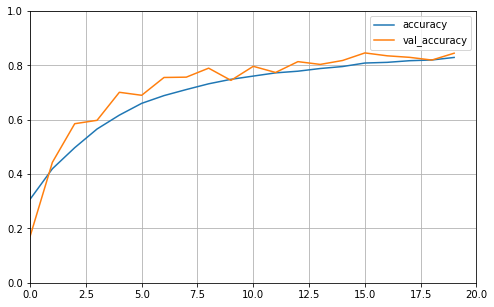

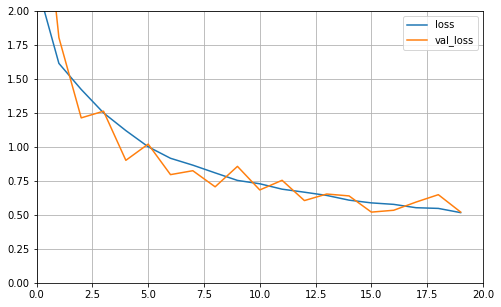

In [15]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [16]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [17]:
# 正式预测
test_predict = model.predict_generator(test_generator,
                                       workers = 3,
                                       use_multiprocessing = True)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [18]:
print(test_predict.shape)

(300000, 10)


In [19]:
print(test_predict[0:5])

[[1.0432401e-01 9.5843628e-02 3.9092276e-02 1.5465358e-01 1.0063549e-01
  4.0646728e-02 3.1479482e-02 2.9842138e-02 1.8830433e-02 3.8465223e-01]
 [9.9680531e-01 3.6376783e-05 4.2367916e-04 6.8557914e-05 5.7347163e-05
  6.5358741e-05 7.0586638e-04 5.2897736e-05 3.2018856e-04 1.4644426e-03]
 [2.7071899e-08 9.9997401e-01 1.5141208e-09 4.6047968e-11 1.8533126e-11
  4.9709187e-10 4.1539029e-11 2.8108160e-11 6.0665272e-08 2.5869280e-05]
 [2.4715494e-03 9.9860923e-04 5.0779232e-05 1.0592443e-05 3.6207327e-06
  4.5571392e-06 3.3111996e-06 5.9014046e-06 9.9599046e-01 4.6071745e-04]
 [9.9579310e-01 7.4242480e-06 3.2204443e-03 1.2513029e-04 1.2351960e-04
  9.5428790e-05 5.6345591e-05 5.0091101e-05 4.9397780e-04 3.4505571e-05]]


## 预测结果提交

In [20]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [21]:
print(test_predict_class_indices[0:5])

[9 0 1 8 0]


In [22]:
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]

In [23]:
print(test_predict_class[0:5])

['truck', 'airplane', 'automobile', 'ship', 'airplane']


In [24]:
# 产生最终的报告
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "../submission.csv"
generate_submissions(output_file, test_predict_class)

In [25]:
!ls ..

input  lib  submission.csv  working
